In [1]:
import pandas as pd
#import pyvista as pv
import matplotlib.pyplot as plt
import nibabel as nib
from nibabel.testing import data_path
import glob
import os
from nilearn import plotting,image
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable


/home/s210382/SimNIBS-4.0/simnibs_env/lib/python3.9/zoneinfo/_tzpath.py:44: InvalidTZPathWarning: Invalid paths specified in PYTHONTZPATH environment variable. Paths should be absolute but found the following relative paths:
    simnibs_env/share/zoneinfo
    simnibs_env/share/tzinfo
  warnings.warn(


## Helper functions

In [2]:
from matplotlib import cm
def plot_2Dimg(data,steps = 10,normalize=False):
    coords = ['X','Y','Z']
    for coord_idx,coord in enumerate(coords):
        fig = plt.figure(coord_idx,figsize=(25, 25))
        fig.suptitle(coord+' component', fontsize=14,y=0.9)
        for idx,a in enumerate(np.linspace(0,data.shape[2]-1,steps).astype(int)):
            ax1 = fig.add_subplot(4,4,idx+1)
            im1 = ax1.imshow(data[:,:,a,coord_idx], interpolation='None')
            divider = make_axes_locatable(ax1)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im1, cax=cax, orientation='vertical', format='%.0e')
            
def get_norm(data):
    x_comp_2 = np.square(data[...,0])
    y_comp_2 = np.square(data[...,1])
    z_comp_2 = np.square(data[...,2])
    norm = np.sqrt(x_comp_2 + y_comp_2 + z_comp_2)
    return norm

def plot_norm(data,index=1,name='default'):
    fig = plt.figure(index,figsize=(15, 15))
    steps= 3
    fig.suptitle(name, fontsize=10,y=0.7)
    for idx,a in enumerate(np.linspace(0,data.shape[2]-1,steps).astype(int)):
        ax1 = fig.add_subplot(1,3,idx+1)
        im1 = ax1.imshow(data[:,:,idx], interpolation='None')
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical', format='%.0e')

# Victor's COMSOL Coils

When exporting data from COMSOL. Ensure that the following components are exported **magnetic vector potential (MVP)** and **magnetic flux density (MFD)**. Furthermore, do not include the header information.

- Ax, Ay, Az are the magnetic vector potential components
- Bx, By, Bz are the magnetic flux density components

In [3]:
import numpy as np

In [222]:
filename = '/home/s210382/Insai/Comsol/Insai/coil70mm.txt'
filename = '/home/s210382/Insai/Comsol/Insai/coil_insai.txt'

In [223]:
columns = ['x','y','z','Ax','Ay','Az']
data = pd.read_csv(filename,delim_whitespace=True,names=columns)
#data.dropna(inplace=True)
data.sort_values(by=['x','y','z'],inplace=True)
data.head()

,x,y,z,Ax,Ay,Az
0,-300.0,-200.0,-200.0,2.331233e-10,-1.066776e-09,2.150133e-11
9801,-300.0,-200.0,-195.0,2.548321e-10,-1.099235e-09,2.150133e-11
19602,-300.0,-200.0,-190.0,2.665805e-10,-1.151787e-09,-1.290139e-12
29403,-300.0,-200.0,-185.0,2.809739e-10,-1.203263e-09,-2.044035e-11
39204,-300.0,-200.0,-180.0,2.852265e-10,-1.244042e-09,-2.874095e-11


Retrieve grid coordinates and set the values according to their component direction (x,y,z)

In [224]:
x,y,z, *_,= data.nunique()
data_np = data.to_numpy()

In [225]:
data_np

array([[-3.00000000e+02, -2.00000000e+02, -2.00000000e+02,
         2.33123306e-10, -1.06677594e-09,  2.15013334e-11],
       [-3.00000000e+02, -2.00000000e+02, -1.95000000e+02,
         2.54832113e-10, -1.09923541e-09,  2.15013334e-11],
       [-3.00000000e+02, -2.00000000e+02, -1.90000000e+02,
         2.66580537e-10, -1.15178723e-09, -1.29013930e-12],
       ...,
       [ 3.00000000e+02,  2.00000000e+02, -1.00000000e+01,
        -5.87540685e-10,  2.18795478e-09,  4.68981711e-12],
       [ 3.00000000e+02,  2.00000000e+02, -5.00000000e+00,
        -5.77238759e-10,  2.15137514e-09, -1.20600059e-11],
       [ 3.00000000e+02,  2.00000000e+02,  0.00000000e+00,
        -5.66395967e-10,  2.13450235e-09, -1.20600059e-11]])

In [226]:
data.count

<bound method DataFrame.count of             x      y      z            Ax            Ay            Az
0      -300.0 -200.0 -200.0  2.331233e-10 -1.066776e-09  2.150133e-11
9801   -300.0 -200.0 -195.0  2.548321e-10 -1.099235e-09  2.150133e-11
19602  -300.0 -200.0 -190.0  2.665805e-10 -1.151787e-09 -1.290139e-12
29403  -300.0 -200.0 -185.0  2.809739e-10 -1.203263e-09 -2.044035e-11
39204  -300.0 -200.0 -180.0  2.852265e-10 -1.244042e-09 -2.874095e-11
...       ...    ...    ...           ...           ...           ...
362636  300.0  200.0  -20.0 -5.909274e-10  2.212829e-09  2.968078e-12
372437  300.0  200.0  -15.0 -5.974497e-10  2.212563e-09  4.331089e-12
382238  300.0  200.0  -10.0 -5.875407e-10  2.187955e-09  4.689817e-12
392039  300.0  200.0   -5.0 -5.772388e-10  2.151375e-09 -1.206001e-11
401840  300.0  200.0    0.0 -5.663960e-10  2.134502e-09 -1.206001e-11

[401841 rows x 6 columns]>

In [227]:
121*81*41

401841

In [228]:
data_np.shape

(401841, 6)

In [229]:
data_np[:,3].shape

(401841,)

In [230]:
np.ones(1)

array([1.])

Store the magnetic vector potential and magnetic flux density

In [231]:
data_mvp = np.stack((data_np[:,3].reshape(x,y,z),data_np[:,4].reshape(x,y,z),data_np[:,5].reshape(x,y,z)),axis=-1).astype('float32')
#data_mfd = np.stack((data_np[:,6].reshape(x,y,z),data_np[:,7].reshape(x,y,z),data_np[:,8].reshape(x,y,z)),axis=-1).astype('float32')

In [232]:
data_mvp.shape

(121, 81, 41, 3)

In [233]:
Ax = data_mvp[:,:,:,0]
Ay = data_mvp[:,:,:,1]
Az = data_mvp[:,:,:,2]
dists = [Ax, Ay, Az]

In [234]:
np.shape(data_mvp)

(121, 81, 41, 3)

In [235]:
dists = [np.flip(Ax,axis=-1), np.flip(Ay,axis=-1), np.flip(Az,axis=-1)]

In [236]:
new_mvp = np.stack((np.flip(Ax,axis=-1),np.flip(Ay,axis=-1),np.flip(Az,axis=-1)),axis=-1)

In [237]:
new_mvp.shape

(121, 81, 41, 3)

In [238]:
Az.shape

(121, 81, 41)

In [239]:
plt.figure(figsize=(20, 20)) 


<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [240]:
reverse_idx = range(np.shape(dist)[-1]-1,-1,-1)
print(reverse_idx[0])

40


Max value: 2.1731872e-05
Min value: -1.9105762e-05


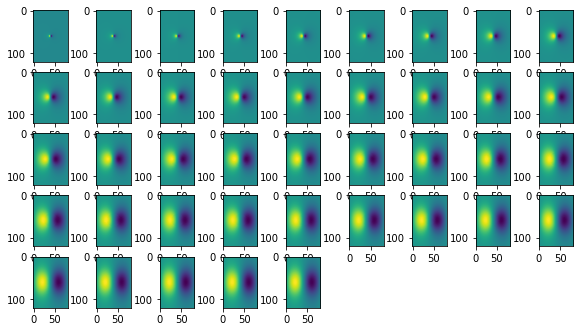

Max value: 2.4076064e-05
Min value: -2.4148285e-05


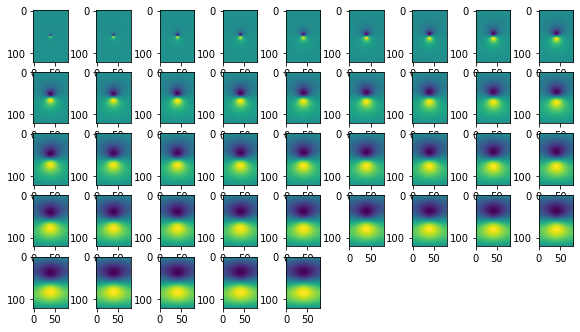

Max value: 4.3905225e-06
Min value: -6.9128996e-06


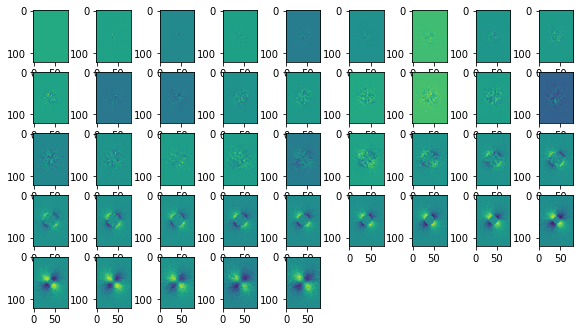

In [241]:
for idx,dist in enumerate(dists):
    print('Max value:',np.max(dist))
    print('Min value:',np.min(dist))
    d_m = []
    fig = plt.figure(idx+1,figsize=(25, 25))
    for i in range(np.shape(dist)[-1]):
        #plt.subplot(9, 9,i + 1)
        ax1 = fig.add_subplot(9, 9,i + 1)
        ax1.imshow(dist[:,:,i])
        plt.gcf().set_size_inches(10, 10)
        d_m.append(np.max(dist[:,:, i]))
    #dist_M.append(d_m)
    plt.show()

In [220]:
1e6/1e6

1.0

In [221]:
20e3/1e6

0.02

In [212]:
np.shape(data_mvp)

(121, 81, 41, 3)

## 2D Plot

Plot the magnetic vector potential

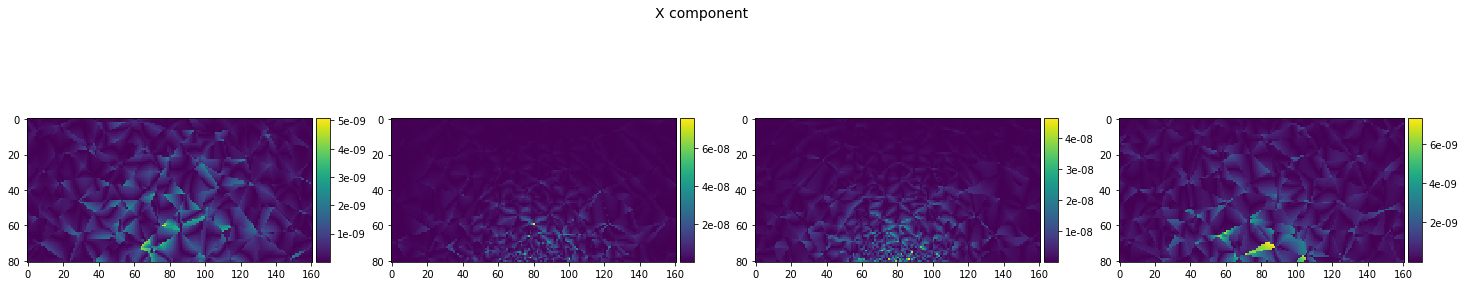

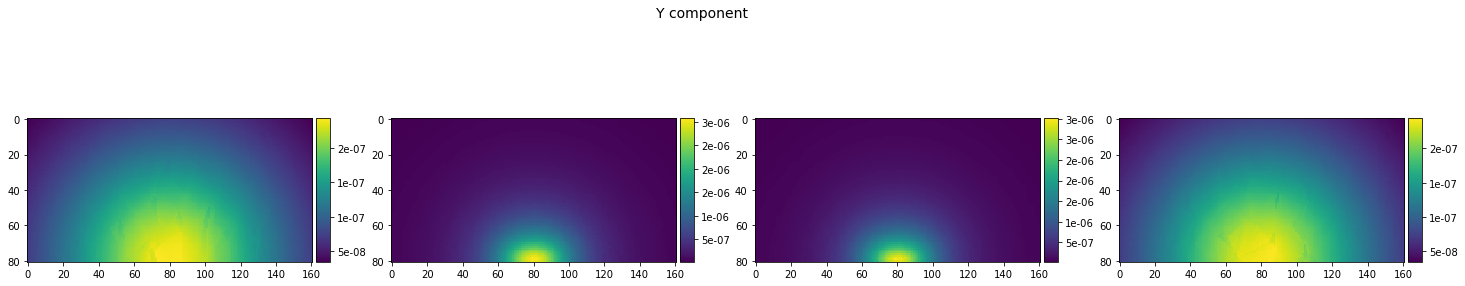

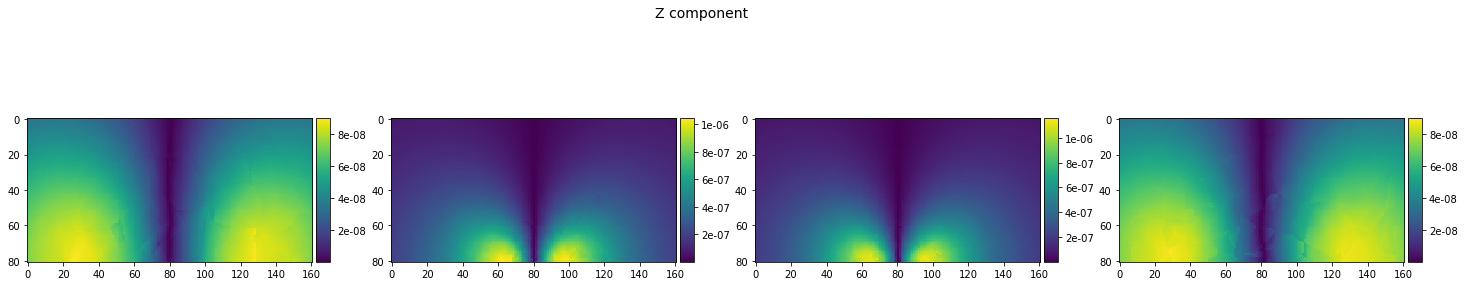

In [67]:
plot_2Dimg(data_mvp,4)

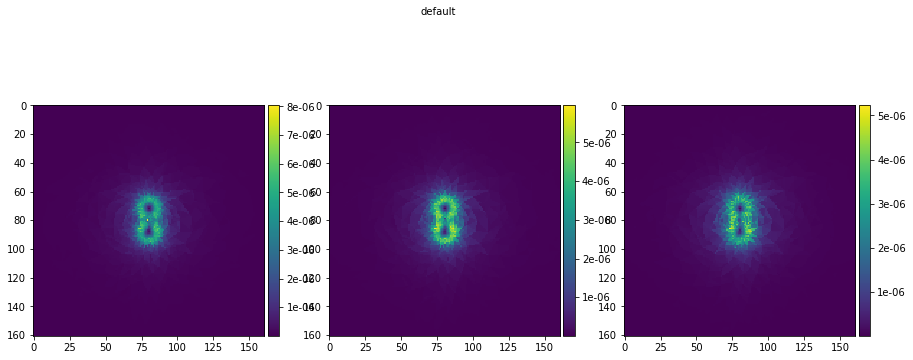

In [8]:
plot_norm(get_norm(data_mvp))

Plot the magnetic field density

In [9]:
#plot_2Dimg(data_mfd,10)

## Create a NIFTI image

The NIFTI File that is saved at the end can be used in SIMNIBS.

Create an affine matrix to specify the matrix transformations. By default, it can be an identify matrix with value 1.

In [242]:
affine = 5*np.eye(4);
affine[:,-1]=[-300,-200,0,1]
affine

array([[   5.,    0.,    0., -300.],
       [   0.,    5.,    0., -200.],
       [   0.,    0.,    5.,    0.],
       [   0.,    0.,    0.,    1.]])

In [243]:
img = nib.Nifti1Image(new_mvp, affine)

In [244]:
save_folder = '/home/s210382/Insai/Comsol/Insai'
save_file = 'coil_insai.nii.gz'

In [245]:
nib.save(img, os.path.join(save_folder,save_file ))

## Load NIFTI Image

In [189]:
img_load = nib.load('./coils/cone_test_new.nii.gz')

FileNotFoundError: No such file or no access: './coils/cone_test_new.nii.gz'

In [15]:
print(img_load.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 4 61 61 61  3  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [1. 0. 0. 0.]
srow_y          : [0. 1. 0. 0.]

## Plotting with NIFTI tools

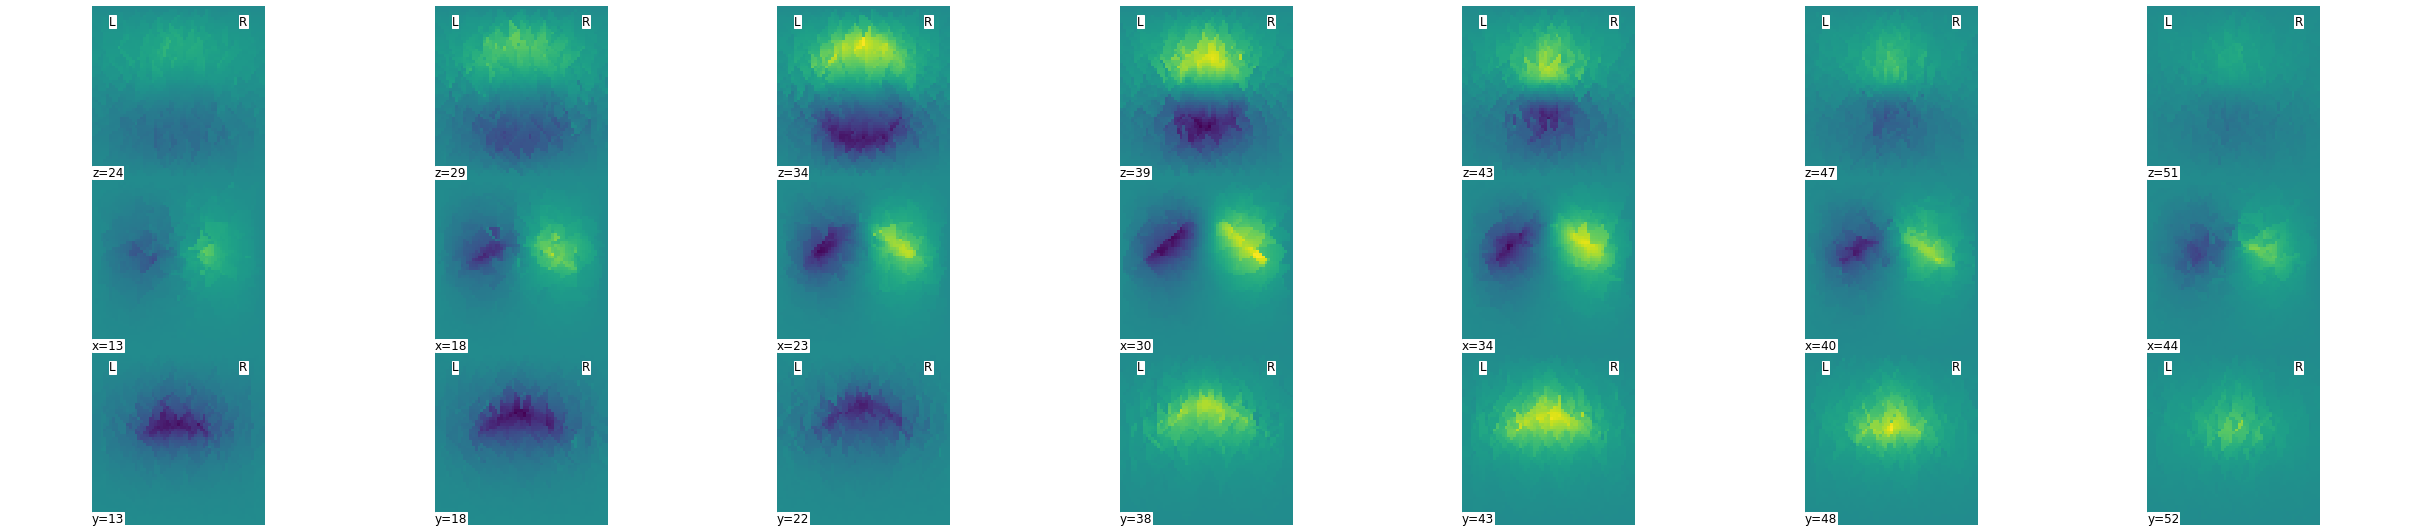

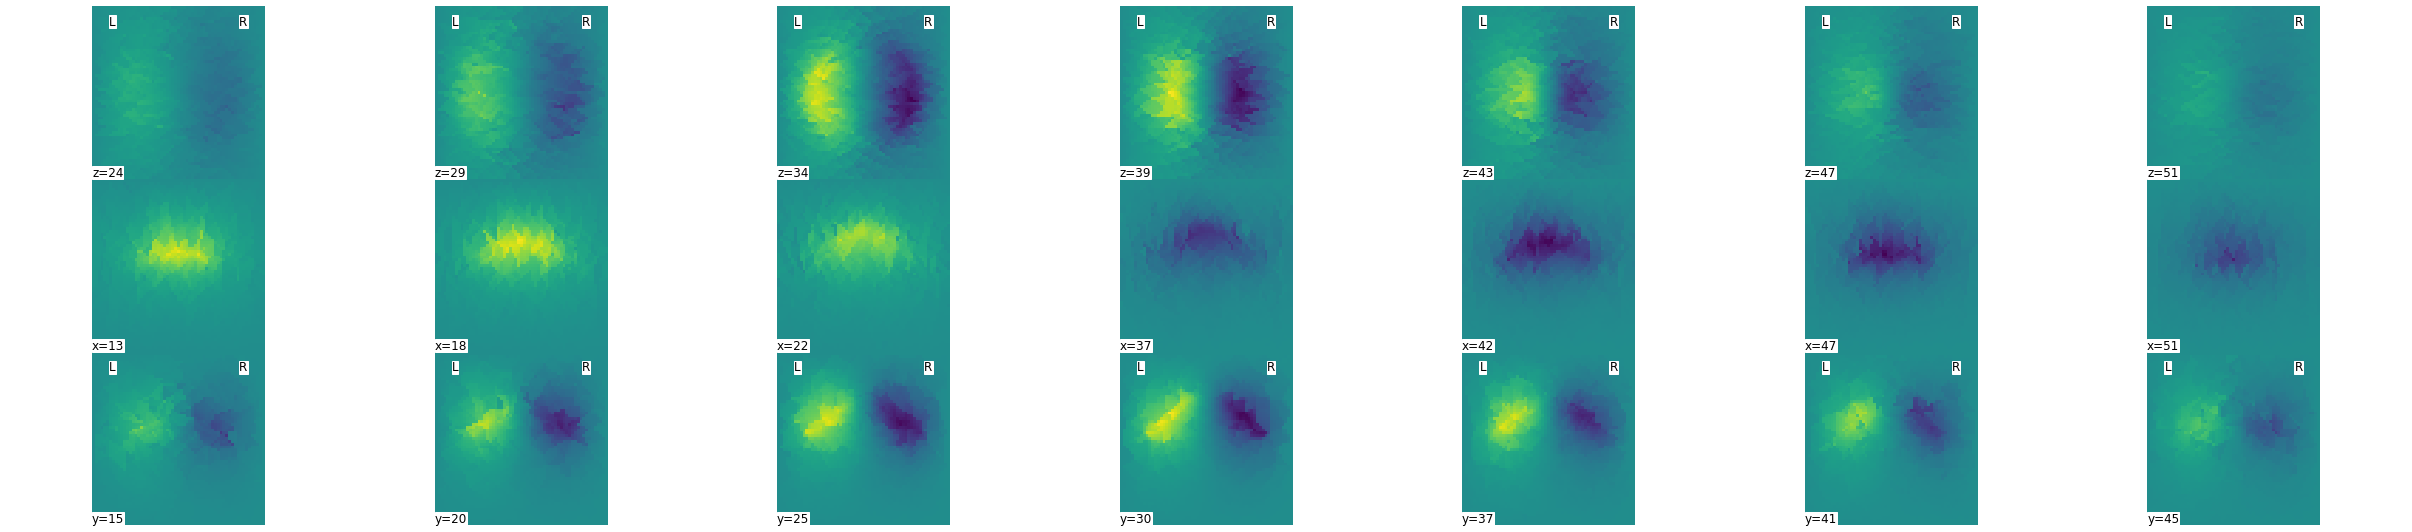

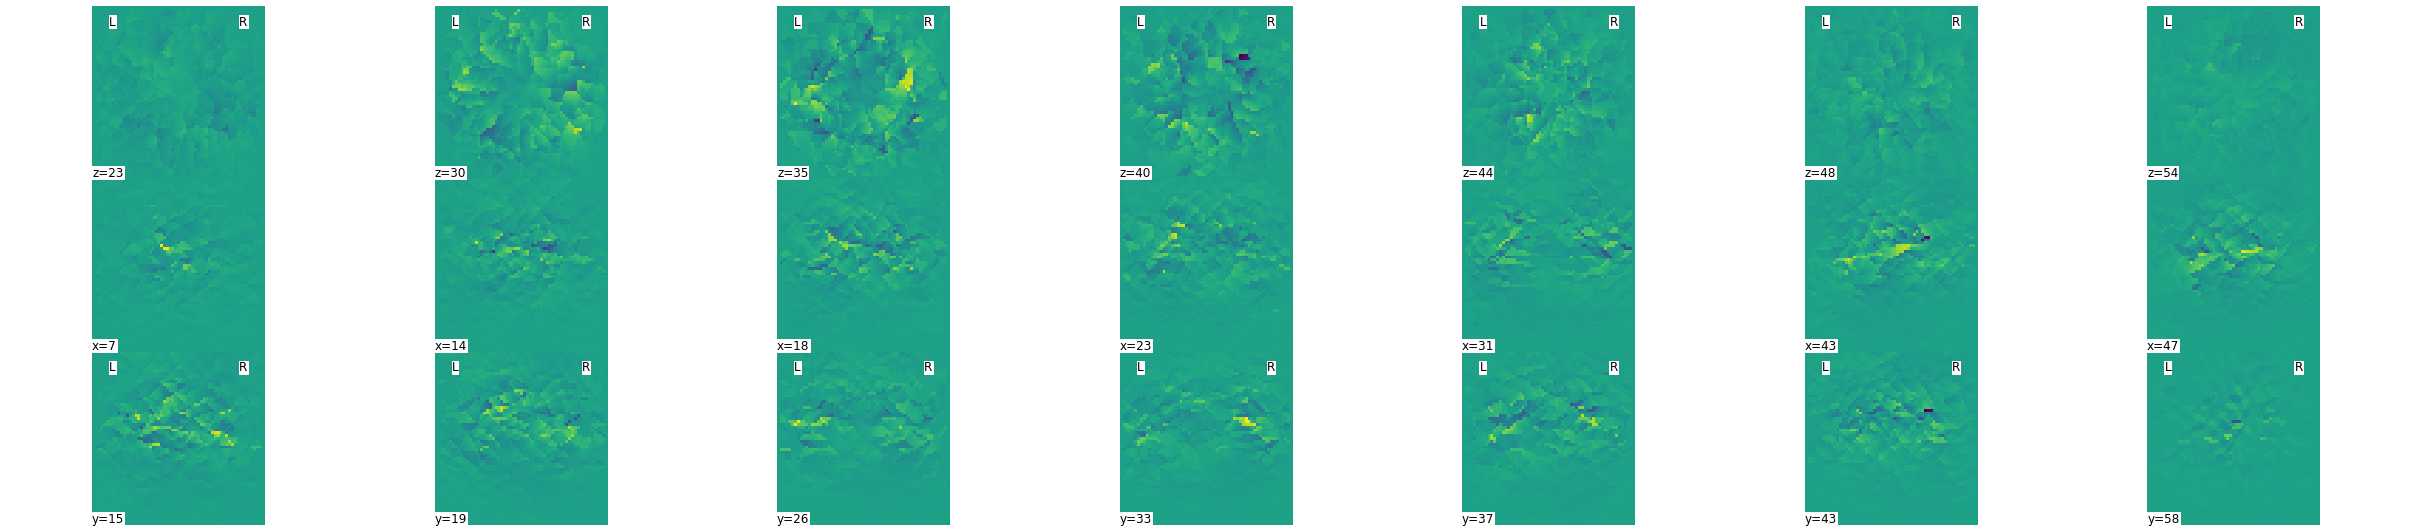

In [16]:
plotting.plot_img(image.index_img(img_load, 0),threshold=None,display_mode = 'mosaic')
plotting.plot_img(image.index_img(img_load, 1),threshold=None,display_mode = 'mosaic')
plotting.plot_img(image.index_img(img_load, 2),threshold=None,display_mode = 'mosaic')

# ZHI-DENG Coils

In [17]:
coil_files = glob.glob('/Volumes/Samsung_T5/Macbook/kaleem/Insai/Coils/SIMNIBS/simnibs-coils/*')
coil_files.sort()
coil_files


['/Volumes/Samsung_T5/Macbook/kaleem/Insai/Coils/SIMNIBS/simnibs-coils/MagVenture_MC_B70.nii.gz',
 '/Volumes/Samsung_T5/Macbook/kaleem/Insai/Coils/SIMNIBS/simnibs-coils/Magstim_70mm_Fig8.nii.gz',
 '/Volumes/Samsung_T5/Macbook/kaleem/Insai/Coils/SIMNIBS/simnibs-coils/No04_Magstim_circular_70mm.nii.gz',
 '/Volumes/Samsung_T5/Macbook/kaleem/Insai/Coils/SIMNIBS/simnibs-coils/No05_Magstim_circular_90mm.nii.gz',
 '/Volumes/Samsung_T5/Macbook/kaleem/Insai/Coils/SIMNIBS/simnibs-coils/No06_MST_animal.nii.gz',
 '/Volumes/Samsung_T5/Macbook/kaleem/Insai/Coils/SIMNIBS/simnibs-coils/No07_MST_human_circular.nii.gz',
 '/Volumes/Samsung_T5/Macbook/kaleem/Insai/Coils/SIMNIBS/simnibs-coils/No09_H1.nii.gz',
 '/Volumes/Samsung_T5/Macbook/kaleem/Insai/Coils/SIMNIBS/simnibs-coils/No20_Numerical_Helmholtz.nii.gz',
 '/Volumes/Samsung_T5/Macbook/kaleem/Insai/Coils/SIMNIBS/simnibs-coils/No21_Three_Layer_Double_Coil.nii.gz',
 '/Volumes/Samsung_T5/Macbook/kaleem/Insai/Coils/SIMNIBS/simnibs-coils/No25_Magstim_Figu

In [18]:
img = nib.load(coil_files[0])
data = img.get_fdata();
data.shape

(121, 81, 41, 3)

In [19]:
data_3 = data[...,2]
data_3.shape

(121, 81, 41)

View the image header below, see differences between Zhi-deng's coils and ours. For example, notice the difference in pixdim, xyzt_units, srow_x, srow_y and srow_z. I believe this has to do with the discretization and boundary boxes

In [20]:
#print(img.header)

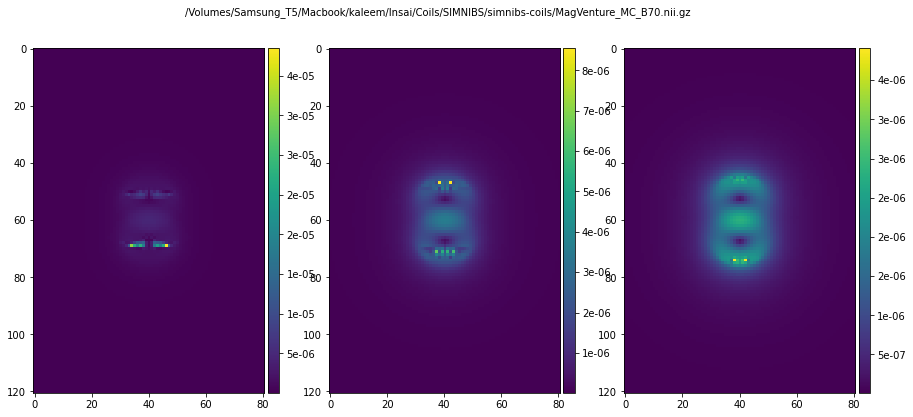

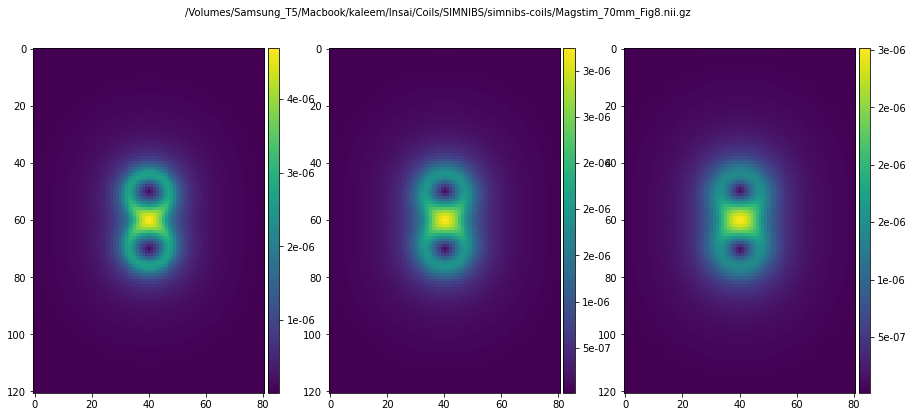

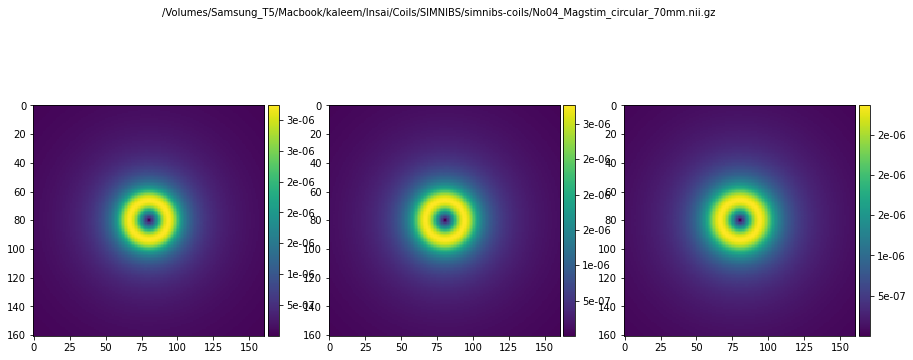

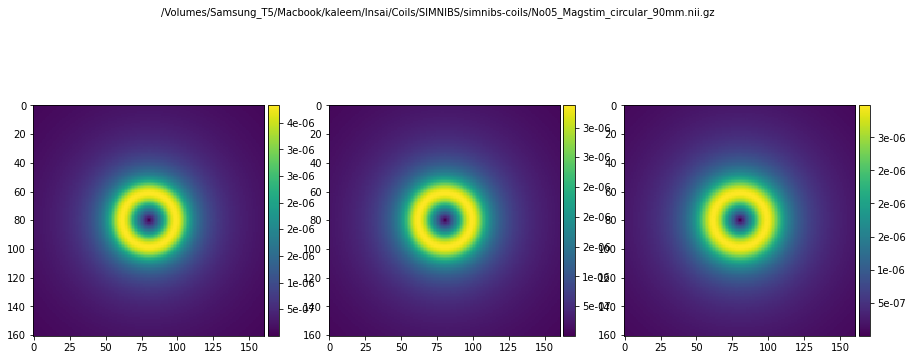

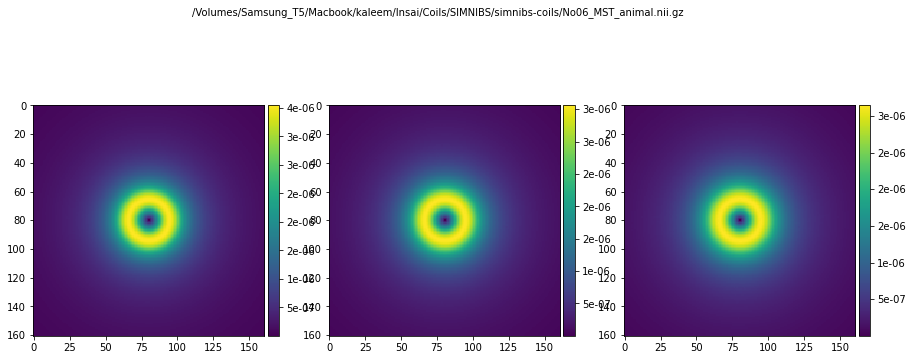

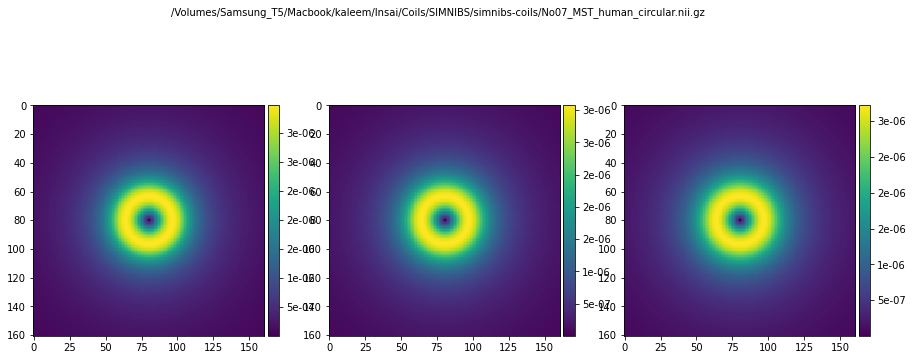

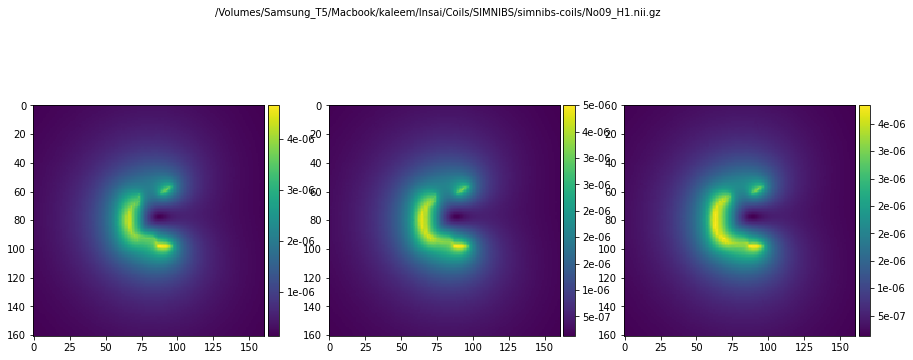

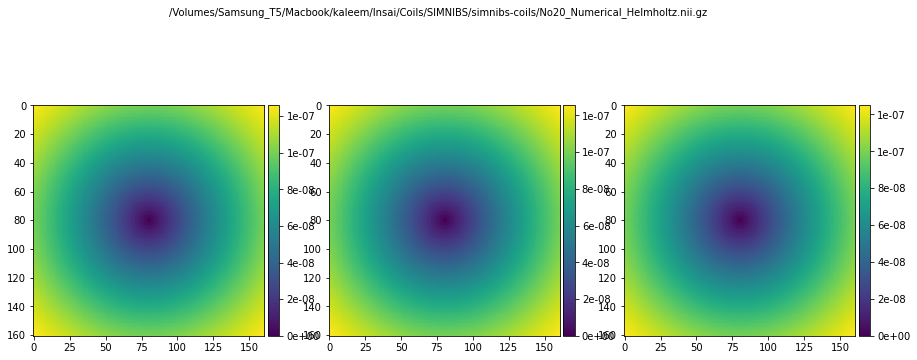

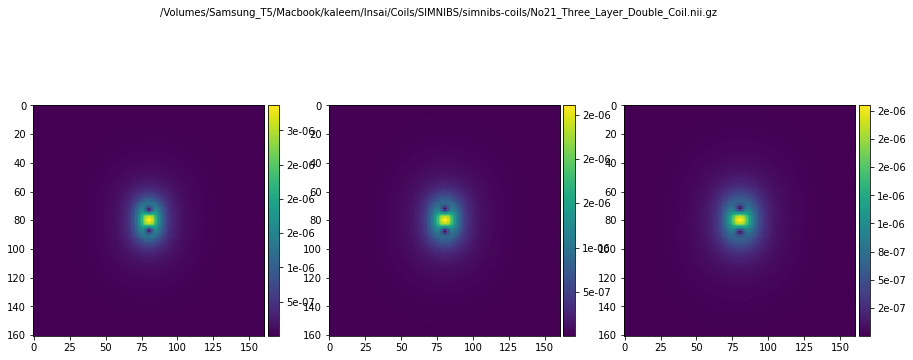

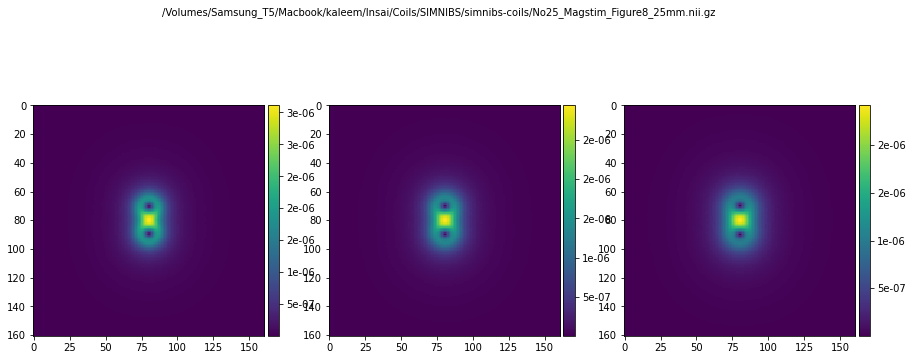

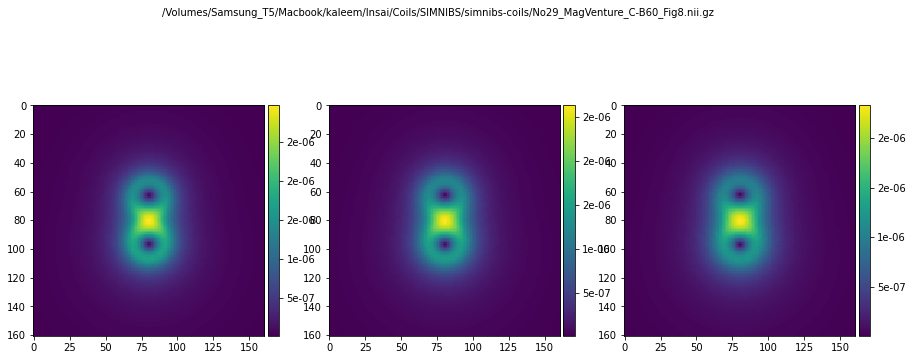

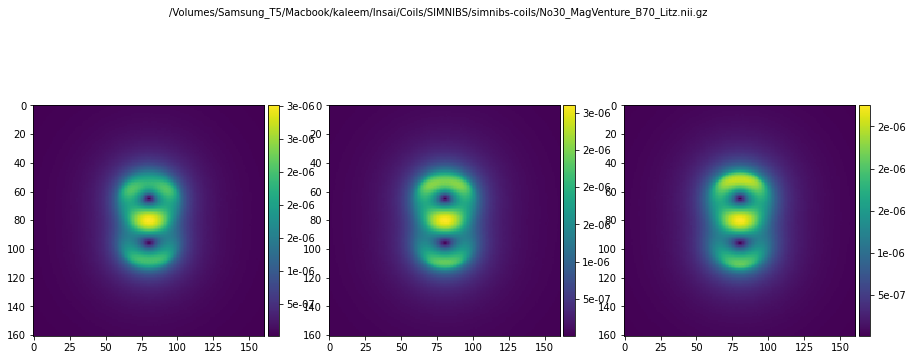

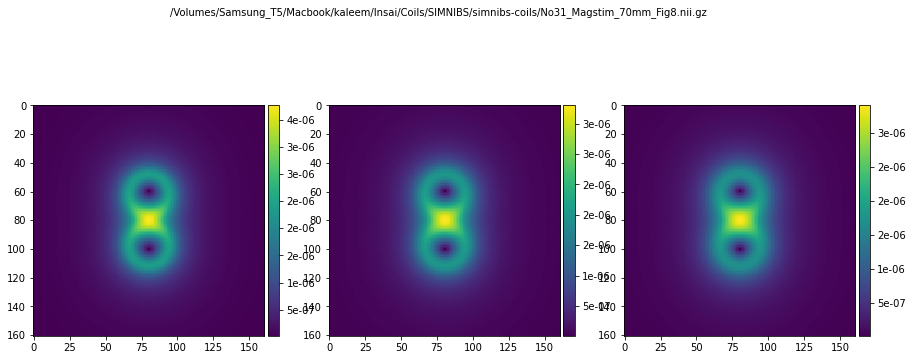

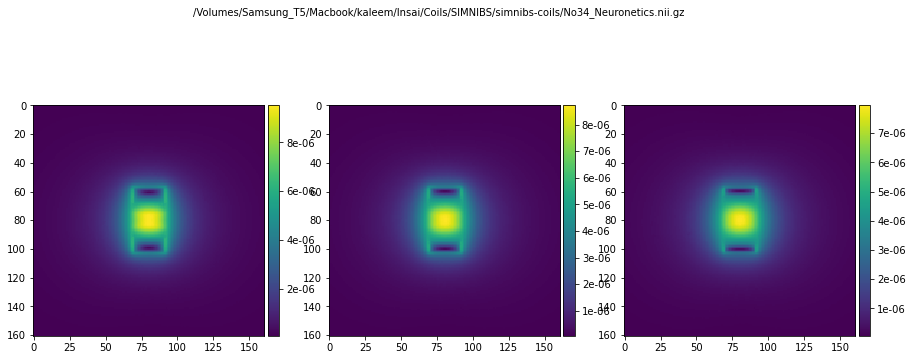

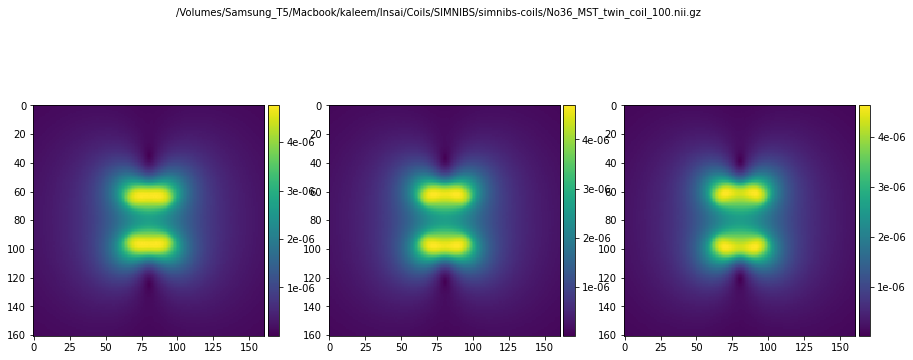

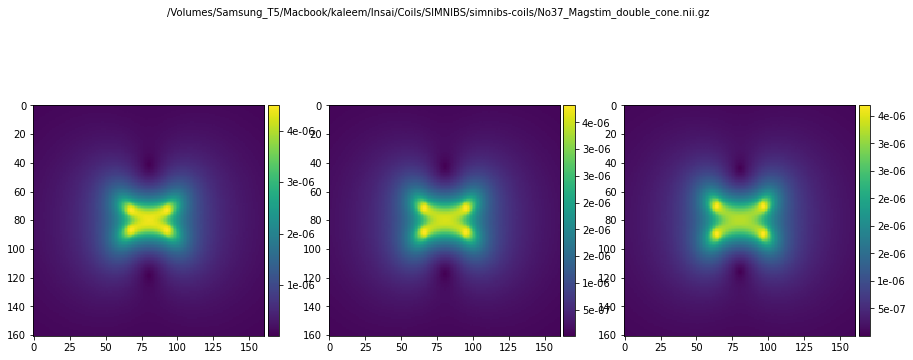

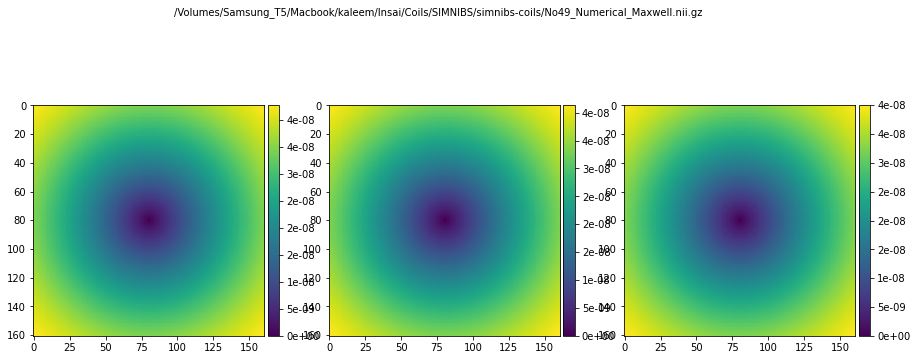

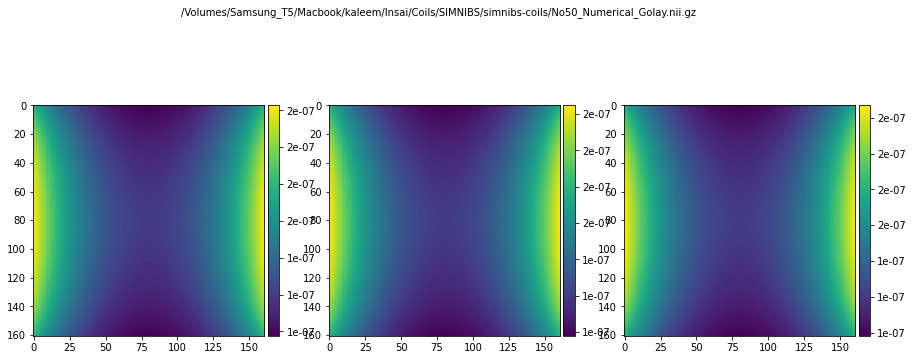

In [21]:
for idx,coil in enumerate(coil_files):
    img = nib.load(coil)
    data = img.get_fdata();
    plot_norm(get_norm(data),idx,coil)

## 2D Plot

ValueError: num must be 1 <= num <= 16, not 17

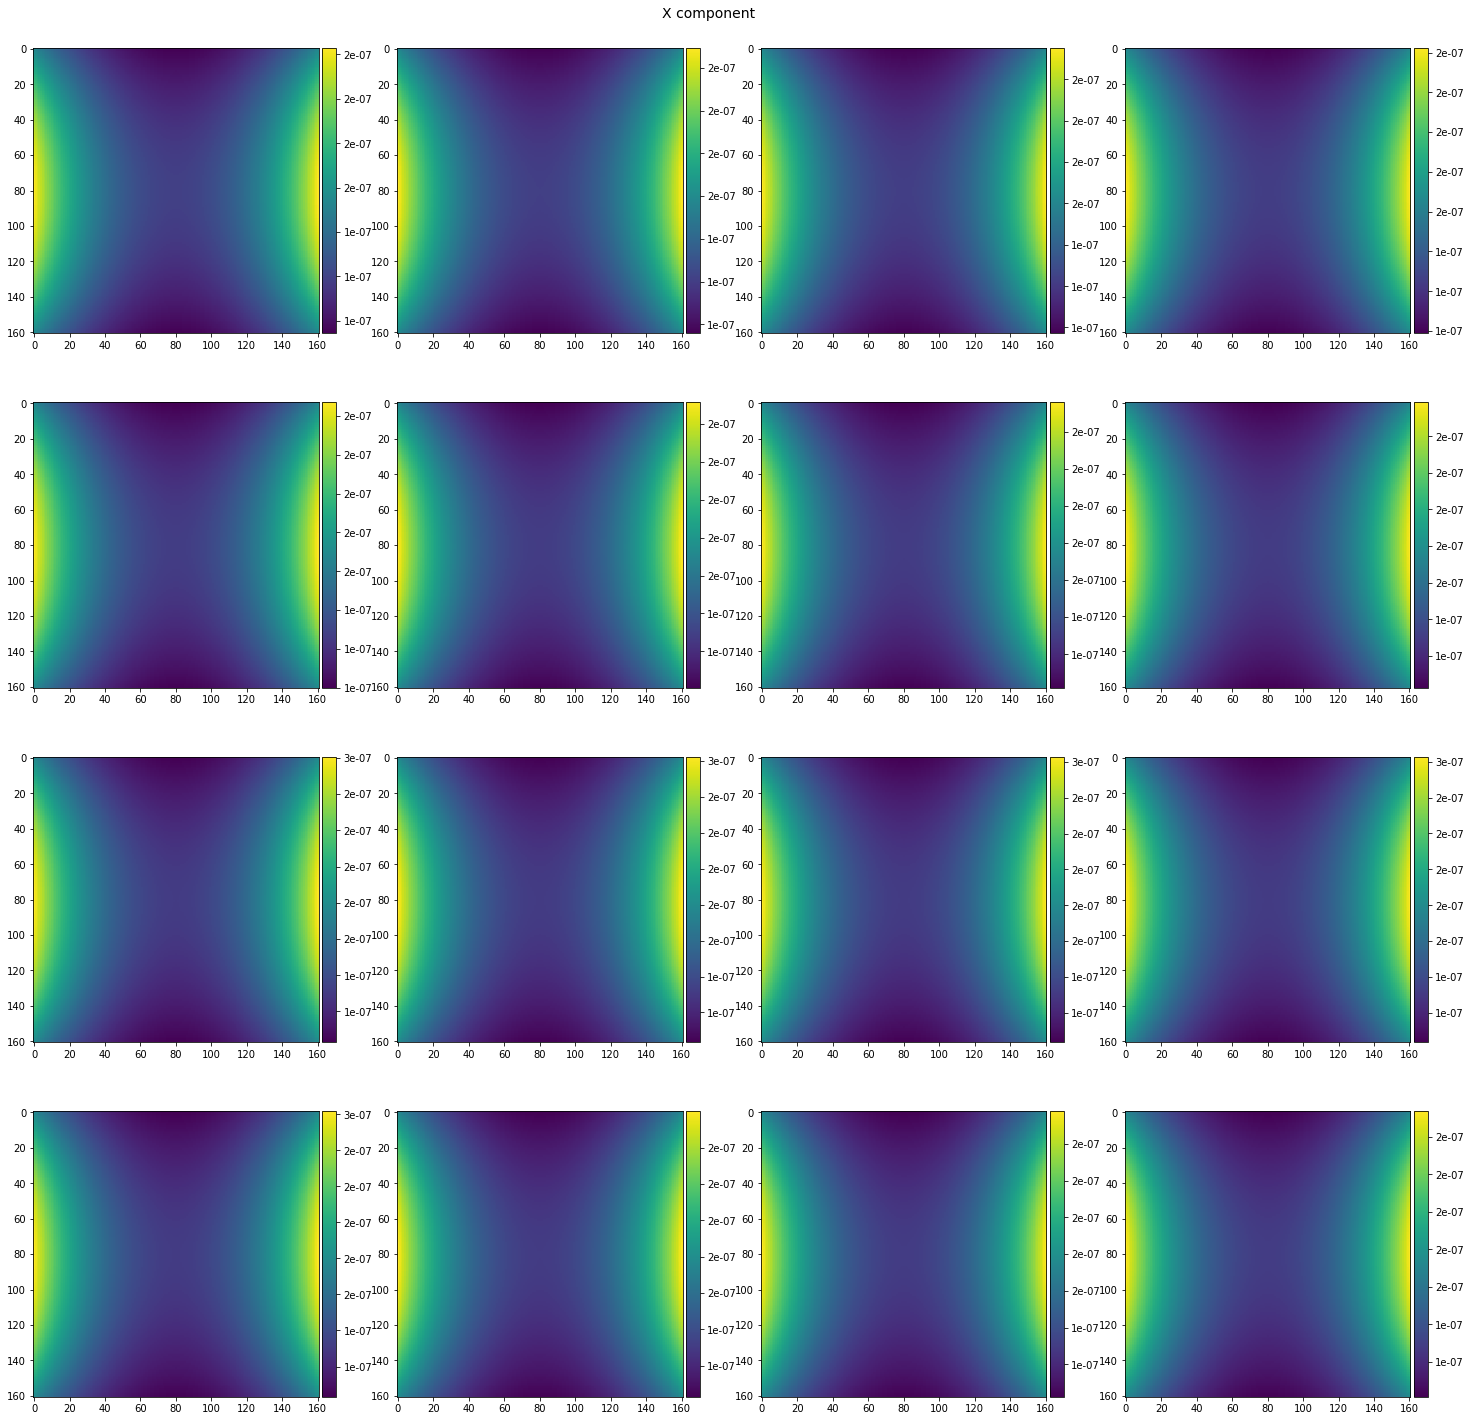

In [22]:
plot_2Dimg(data,25)

## Plotting with NIFTI tools

In [ ]:
plotting.plot_img(image.index_img(img, 0),threshold=None,display_mode = 'mosaic',colorbar=True)
plotting.plot_img(image.index_img(img, 1),threshold=None,display_mode = 'mosaic',colorbar=True)
plotting.plot_img(image.index_img(img, 2),threshold=None,display_mode = 'mosaic',colorbar=True)

# Archive

In [ ]:

# read the data
grid = pv.read('/Users/Kaleem/Downloads/VTK_Cone.vtu')

# plot the data with an automatically created Plotter
#grid.plot(show_scalar_bar=False, show_axes=False)

In [ ]:
coil_files = glob.glob('/Users/Kaleem/Insai/Coils/SIMNIBS/simnibs-coils/*')
for idx,coil_file in enumerate(coil_files):
    print(coil_file)
    plt.figure(idx+1)
    plotting.plot_img(image.index_img(coil_file, 0),threshold=None,display_mode = 'mosaic')
    #plotting.plot_stat_map(image.index_img(coil_file, 0))
    #img = nib.load(coil_file)
    
    #data = img.get_fdata(); 
    #plot_img(data)

    #print(img.header)

In [ ]:
coil_files = glob.glob('/Users/Kaleem/Insai/Coils/SIMNIBS/simnibs-coils/*')
for idx,coil_file in enumerate(coil_files[0:2]):
    print(coil_file)
    img = nib.load(coil_file)
    print(img.header['dim'])
    print(img.header['pixdim'])
    print(img.header.get_best_affine())
    print(img.header.get_qform())
    print(img.header.get_sform())
    print(img.header.get_xyzt_units())